In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, pydash, math, os, itertools
from pydash import flatten, flatten_deep
from collections import Counter, OrderedDict
from frozendict import frozendict
from humanize import intcomma
from operator import itemgetter
from typing import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from itertools import product, combinations
from joblib import Parallel, delayed

In [2]:
df_train = pd.read_csv('dataset/train.csv', index_col=0)
df_test  = pd.read_csv('dataset/test.csv', index_col=0)
df_train.head()


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df = df_train
total_count = df['target'].count()
value_counts = df['target'].value_counts()
print("Tổng số phần tử:", total_count)
print("\nSố lượng của mỗi giá trị trong cột 'target':")
print(value_counts)


Tổng số phần tử: 7613

Số lượng của mỗi giá trị trong cột 'target':
target
0    4342
1    3271
Name: count, dtype: int64


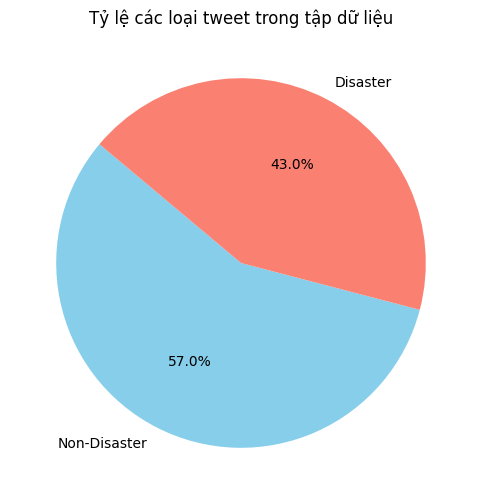

In [6]:
value_counts = df['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    value_counts, 
    labels=['Non-Disaster', 'Disaster'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['skyblue', 'salmon']
)
plt.title("Tỷ lệ các loại tweet trong tập dữ liệu")
plt.show()

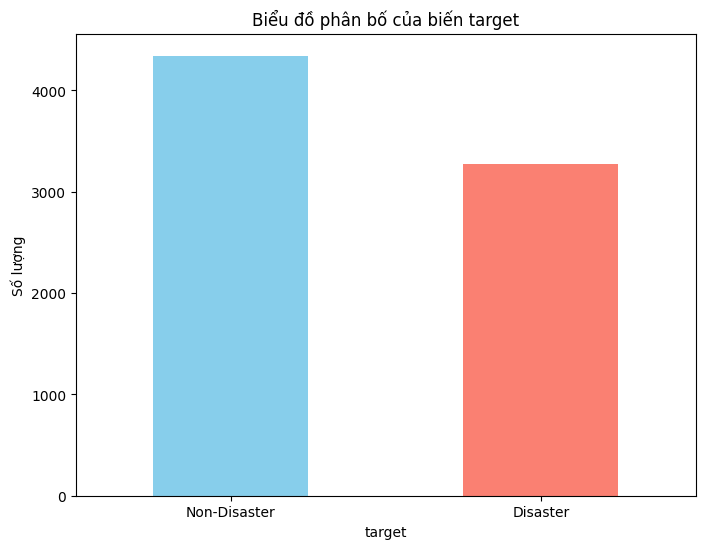

In [5]:
plt.figure(figsize=(8, 6))
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Biểu đồ phân bố của biến target')
plt.xlabel('target')
plt.ylabel('Số lượng')
plt.xticks(ticks=[0, 1], labels=['Non-Disaster', 'Disaster'], rotation=0)
plt.show()

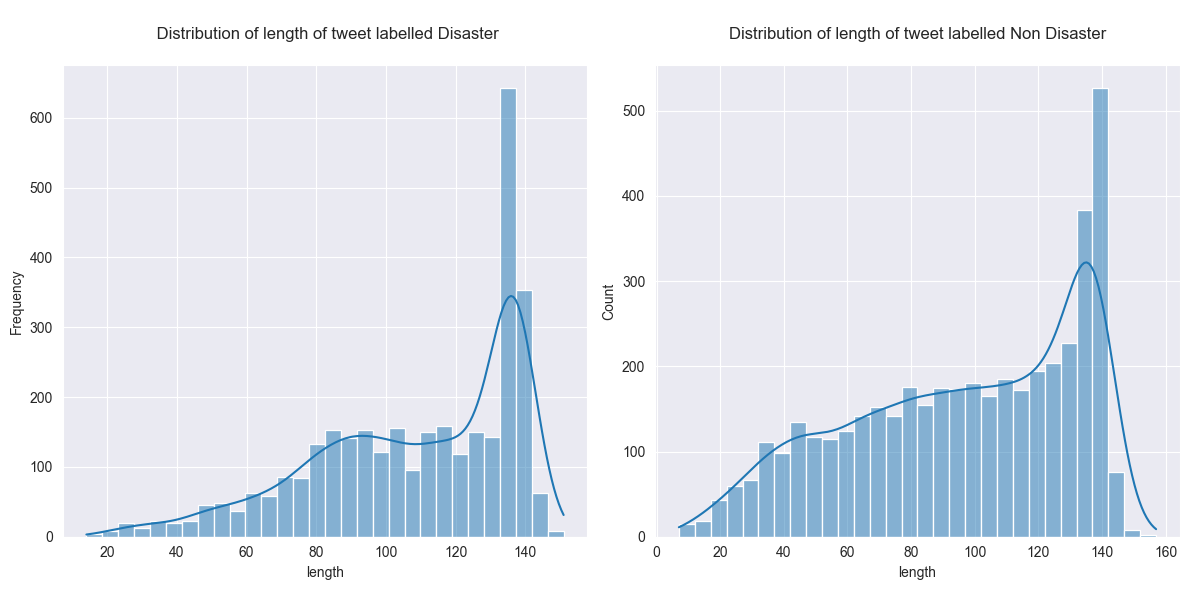

In [7]:
df['length'] = df['text'].apply(len)
df['length'] = df['length'].astype(int)
sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, tight_layout=True)
sns.histplot(df[df['target'] == 1]["length"], bins=30, ax=ax1, kde=True)
sns.histplot(df[df['target'] == 0]["length"], bins=30, ax=ax2, kde=True)
ax1.set_title('\n Distribution of length of tweet labelled Disaster\n')
ax2.set_title('\nDistribution of length of tweet labelled Non Disaster\n ')
ax1.set_ylabel('Frequency')
plt.show()

In [8]:
def tokenize_df(
    dfs: List[pd.DataFrame], 
    keys          = ('text', 'keyword', 'location'), 
    stemmer       = True, 
    preserve_case = True, 
    reduce_len    = False, 
    strip_handles = True,
    use_stopwords = True,
    **kwargs,
) -> List[List[str]]:
    tokenizer = nltk.TweetTokenizer(preserve_case=preserve_case, reduce_len=reduce_len, strip_handles=strip_handles) 
    porter    = nltk.PorterStemmer()
    stopwords = set(nltk.corpus.stopwords.words('english') + [ 'nan' ])
    output    = []
    for df in flatten([ dfs ]):
        for index, row in df.iterrows():
            tokens = flatten([ tokenizer.tokenize(str(row[key] or "")) for key in keys])
            if use_stopwords:
                tokens = [ token for token in tokens if token.lower() not in stopwords and len(token) >= 2]                
            if stemmer:
                tokens = [ porter.stem(token) for token in tokens ]
            output.append(tokens)
    return output

In [15]:
with open("stopwords/english", "r") as file:
    words = [line.strip() for line in file]
columns = 10
rows = [words[i:i + columns] for i in range(0, len(words), columns)]
new = pd.DataFrame(rows)
new.to_csv('stopwords.csv', index=False)
new

,0,1,2,3,4,5,6,7,8,9
0,i,me,my,myself,we,our,ours,ourselves,you,you're
1,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his
2,himself,she,she's,her,hers,herself,it,it's,its,itself
3,they,them,their,theirs,themselves,what,which,who,whom,this
4,that,that'll,these,those,am,is,are,was,were,be
5,been,being,have,has,had,having,do,does,did,doing
6,a,an,the,and,but,if,or,because,as,until
7,while,of,at,by,for,with,about,against,between,into
8,through,during,before,after,above,below,to,from,up,down
9,in,out,on,off,over,under,again,further,then,once


In [11]:
tokenize_df(df_train)[:5]

[['deed', 'reason', '#earthquak', 'may', 'allah', 'forgiv', 'us'],
 ['forest', 'fire', 'near', 'la', 'rong', 'sask', 'canada'],
 ['resid',
  'ask',
  'shelter',
  'place',
  'notifi',
  'offic',
  'evacu',
  'shelter',
  'place',
  'order',
  'expect'],
 ['13,000', 'peopl', 'receiv', '#wildfir', 'evacu', 'order', 'california'],
 ['got',
  'sent',
  'photo',
  'rubi',
  '#alaska',
  'smoke',
  '#wildfir',
  'pour',
  'school']]

In [41]:
def word_frequencies(df, **kwargs) -> Dict[int, Counter]:
    tokens = {
        0: flatten(tokenize_df( df[df['target'] == 0], **kwargs )),
        1: flatten(tokenize_df( df[df['target'] == 1], **kwargs )),
    }
    freqs = { 
        target: Counter(dict(Counter(tokens[target]).most_common())) 
        for target in [0, 1]
    }
    return freqs

In [42]:
freqs = word_frequencies(df_train)
print('freqs[0]', len(freqs[0]), freqs[0].most_common(10))
print('freqs[1]', len(freqs[1]), freqs[1].most_common(10))

freqs[0] 12811 [('...', 421), ('new', 320), ('like', 309), ('get', 224), ('bodi', 216), ("i'm", 207), ('scream', 194), ('û_', 171), ('burn', 159), ('obliter', 157)]
freqs[1] 10795 [('...', 637), ('fire', 303), ('bomb', 242), ('new', 207), ('suicid', 204), ('evacu', 185), ('flood', 176), ('û_', 171), ('derail', 170), ('kill', 160)]


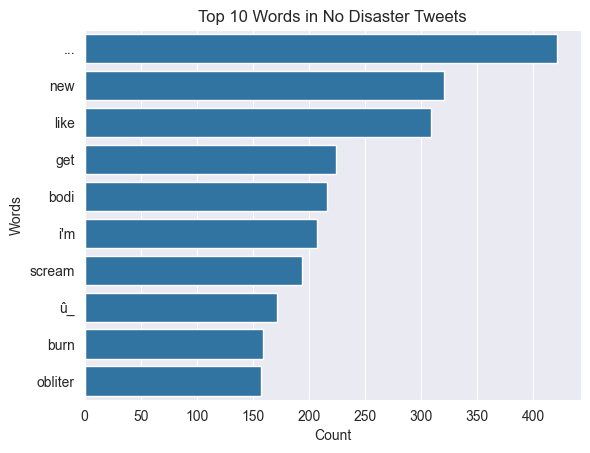

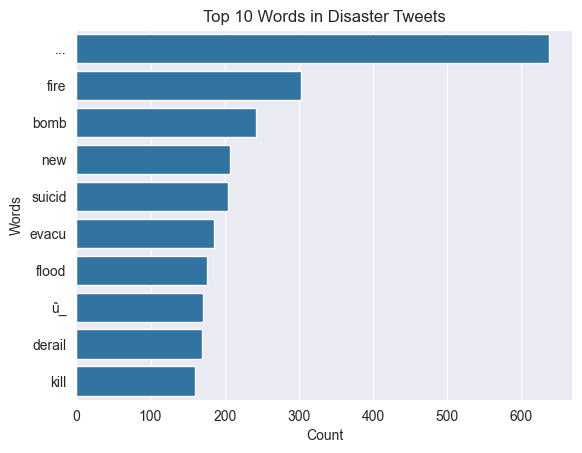

In [ ]:
def plot_top_words(freqs, target_group, top_n=10):
    stopwords = set(nltk.corpus.stopwords.words('english') + ['nan'])
    counter = freqs[target_group].most_common()
    x, y = [], []
    count = 0
    for word, freq in counter:
        if count >= top_n:
            break
        if word not in stopwords:
            x.append(word)
            y.append(freq)
            count += 1
    sns.barplot(x=y, y=x)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.title(f"Top {top_n} Words in {'Disaster' if target_group == 1 else 'No Disaster'} Tweets")
    plt.show()

plot_top_words(freqs, target_group=0)
plot_top_words(freqs, target_group=1)


In [46]:
def inverse_document_frequency( tokens: List[str] ) -> Counter:
    tokens = flatten_deep(tokens)
    idf = {
        token: math.log( len(tokens) / count ) 
        for token, count in Counter(tokens).items()
    }
    idf = Counter(dict(Counter(idf).most_common()))
    return idf

In [47]:
def inverse_document_frequency_df( dfs ) -> Counter:
    tokens = flatten_deep([ tokenize_df(df) for df in flatten([ dfs ]) ])
    return inverse_document_frequency(tokens)

In [48]:
idf = inverse_document_frequency_df([ df_train, df_test ])
list(reversed(idf.most_common()))[:20]

[('...', 4.467633783633229),
 ('new', 5.142574999696602),
 ('fire', 5.360577151510393),
 ('like', 5.413220884995814),
 ('û_', 5.568216516288637),
 ('bomb', 5.654690114292464),
 ('get', 5.667677309819275),
 ('burn', 5.792840452773281),
 ('usa', 5.833148176261374),
 ('emerg', 5.8539281447531195),
 ('flood', 5.89136567182525),
 ("i'm", 5.918991738100181),
 ('bodi', 5.935941296413954),
 ('attack', 5.967781902269613),
 ('via', 5.97072741249937),
 ('fatal', 6.000669769114448),
 ('crash', 6.000669769114448),
 ('suicid', 6.015984004087491),
 ('build', 6.025286396749804),
 ('evacu', 6.034676137099644)]

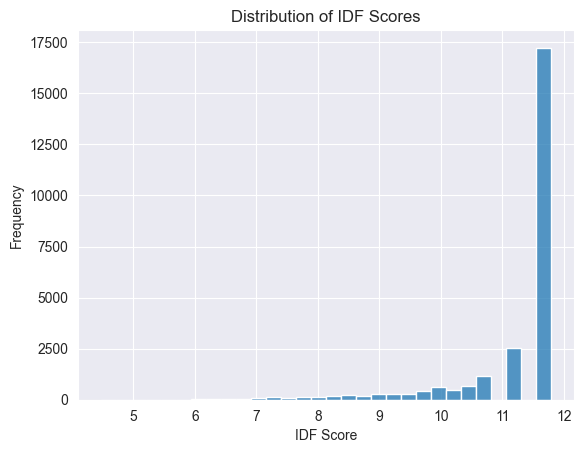

In [52]:
idf_values = [score for word, score in idf.most_common()]
sns.histplot(idf_values, bins=30)
plt.xlabel('IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of IDF Scores')
plt.show()

In [57]:
def extract_features(df, freqs, use_idf=True, use_log=True, **kwargs) -> np.array:
    features = []
    tokens   = tokenize_df(df, **kwargs)
    for n in range(len(tokens)):
        bias     = 1
        positive = 1
        negative = 1        
        for token in tokens[n]:
            if use_idf:
                positive += freqs[0].get(token, 0) * idf.get(token, 1) 
                negative += freqs[1].get(token, 0) * idf.get(token, 1)
            else:
                positive += freqs[0].get(token, 0) 
                negative += freqs[1].get(token, 0) 
        features.append([ positive, negative ])  
    features = np.array(features)
    if use_log:
        features = np.log(features)
    return features

In [58]:
Y_train = df_train['target'].to_numpy()
X_train = extract_features(df_train, freqs)
X_test  = extract_features(df_test,  freqs)
print('df_train', df_train.shape)
print('df_test ', df_test.shape)
print('Y_train ', Y_train.shape)
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print(X_test[:5])

df_train (7613, 5)
df_test  (3263, 3)
Y_train  (7613,)
X_train  (7613, 2)
X_test   (3263, 2)
[[6.92293033 7.38327619]
 [7.14708523 7.00546676]
 [7.29343584 8.00157928]
 [6.36825736 5.77734926]
 [5.70946644 7.56250014]]


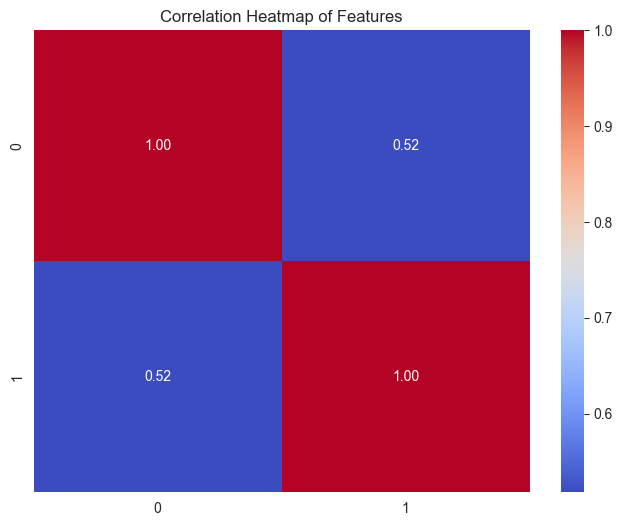

In [62]:
feature_df = pd.DataFrame(X_train)
correlation_matrix = feature_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

In [63]:
def predict_df(df_train, df_test, **kwargs):
    freqs   = word_frequencies(df_train, **kwargs)
    Y_train = df_train['target'].to_numpy()
    X_train = extract_features(df_train, freqs, **kwargs)
    X_test  = extract_features(df_test,  freqs, **kwargs) if df_train is not df_test else X_train
    model      = LinearRegression().fit(X_train, Y_train)
    prediction = model.predict(X_test)
    prediction = np.round(prediction).astype(int)
    return prediction

In [64]:
def get_train_f1_score(splits=3, **kwargs):
    f1 = 0.0
    for _ in range(splits):
        train, test = train_test_split(df_train, test_size=1/splits)      
        prediction  = predict_df(train, test, **kwargs)
        Y_train     = test['target'].to_numpy()
        f1         += f1_score(Y_train, prediction, average='weighted') / splits
    return f1

In [65]:
def train_f1_score_hyperparameter_search():
    results = Counter()
    jobs    = []
    for keys in [('text', 'keyword', 'location')]: 
        strip_handles = 1  
        for stemmer, preserve_case, reduce_len, use_stopwords, use_idf, use_log in product([1,0],[1,0],[1,0],[1,0],[1,0],[1,0]):
            def fn(keys, stemmer, preserve_case, reduce_len, strip_handles, use_stopwords, use_idf, use_log):
                kwargs = {
                    "stemmer":        stemmer,          
                    "preserve_case":  preserve_case, 
                    "reduce_len":     reduce_len, 
                    "use_stopwords":  use_stopwords,    
                    "use_idf":        use_idf,          
                    "use_log":        use_log,          
                }
                label = frozendict({**kwargs})
                f1 = get_train_f1_score(**kwargs)
                return (label, f1)
            jobs.append(delayed(fn)(keys, stemmer, preserve_case, reduce_len, strip_handles, use_stopwords, use_idf, use_log))
    results = Counter(dict(Parallel(-1)(jobs)))
    results = Counter(dict(results.most_common())) 
    return results

In [66]:
results = train_f1_score_hyperparameter_search()
for label, value in results.items():
    print(f'{value:.5f} |', "  ".join(f"{k.split('_')[-1]} = {v}" for k,v in label.items()))
print('train_f1_score = ', get_train_f1_score())
df_submission = pd.DataFrame({
    "id":     df_test.index,
    "target": predict_df(df_train, df_test)
})
df_submission.to_csv('submission.csv', index=False)

0.75736 | stemmer = 1  case = 0  len = 0  stopwords = 1  idf = 1  log = 1
0.75518 | stemmer = 1  case = 1  len = 0  stopwords = 1  idf = 1  log = 1
0.75476 | stemmer = 1  case = 1  len = 0  stopwords = 1  idf = 1  log = 0
0.75437 | stemmer = 1  case = 0  len = 1  stopwords = 1  idf = 1  log = 1
0.75419 | stemmer = 1  case = 1  len = 1  stopwords = 1  idf = 0  log = 1
0.75162 | stemmer = 1  case = 0  len = 0  stopwords = 1  idf = 1  log = 0
0.75102 | stemmer = 1  case = 0  len = 0  stopwords = 1  idf = 0  log = 1
0.75088 | stemmer = 1  case = 1  len = 1  stopwords = 1  idf = 1  log = 0
0.74891 | stemmer = 1  case = 1  len = 1  stopwords = 1  idf = 1  log = 1
0.74879 | stemmer = 0  case = 0  len = 0  stopwords = 1  idf = 0  log = 0
0.74581 | stemmer = 0  case = 0  len = 1  stopwords = 1  idf = 0  log = 1
0.74543 | stemmer = 0  case = 1  len = 0  stopwords = 1  idf = 0  log = 1
0.74513 | stemmer = 1  case = 1  len = 0  stopwords = 1  idf = 0  log = 1
0.74420 | stemmer = 0  case = 1  len =

In [74]:
submission = pd.read_csv('submission.csv', index_col=0)
testing = pd.read_csv('dataset/test.csv', index_col=0)
testing['target'] = submission['target']
testing.to_csv('results.csv', index=False)

In [76]:
new = pd.read_csv('results.csv')
new.head()

,keyword,location,text,target
0,NaN,NaN,Just happened a terrible car crash,1
1,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
